## Imports

In [1]:
!pip install textstat --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.1/239.1 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.1 MB/s eta 0:00:00


In [15]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import re
import matplotlib.pyplot as plt
import textstat
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = ""

SEED = 312
N_BOOTSTRAP = 5000

## Data

In [ ]:
df = pd.read_csv(DATA_PATH)

assert not df.isnull().values.any()
assert df.readability_score.apply(lambda x: isinstance(x, float)).all()
assert df.assessment.apply(lambda x: x in {2, 3, 4}).all()

df.head()

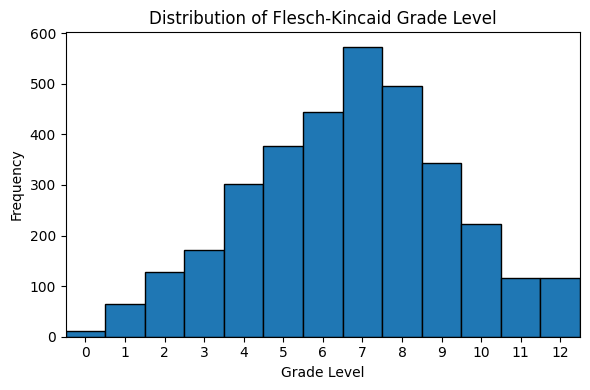

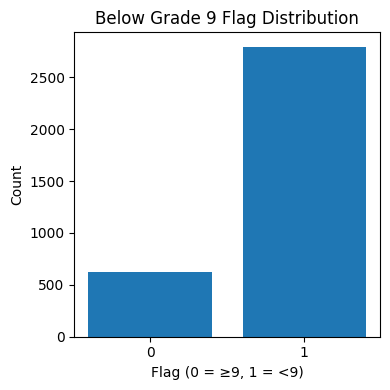

In [18]:
scores = df["readability_score"]
max_grade = int(np.ceil(scores.max()))
plt.figure(figsize=(6, 4))

bins = np.arange(-0.5, max_grade + 1.5, 1)
plt.hist(scores, bins=bins, edgecolor="black")

plt.title("Distribution of Flesch-Kincaid Grade Level")
plt.xlabel("Grade Level")
plt.ylabel("Frequency")

plt.xlim(-0.5, max_grade + 0.5)
plt.xticks(np.arange(0, max_grade + 1, 1))

plt.tight_layout()

flag_counts = df["below_grade_9"].value_counts().sort_index()

plt.figure(figsize=(4, 4))
plt.bar(flag_counts.index.astype(str), flag_counts.values)

plt.title("Below Grade 9 Flag Distribution")
plt.xlabel("Flag (0 = ≥9, 1 = <9)")
plt.ylabel("Count")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [19]:
M,SD  = df["readability_score"].mean(), df["readability_score"].std(ddof=1)

print(f"M={M:.3f}, SD={SD:.3f}")

M=6.576, SD=2.736


## Confidence Intervals

In [20]:
flags  = df["below_grade_9"].astype(float).to_numpy()
scores = df["readability_score"].to_numpy()

rng      = np.random.default_rng(SEED)
n_boot   = N_BOOTSTRAP
alpha    = 0.95
pct_low  = (1-alpha)/2 * 100
pct_high = (1+alpha)/2 * 100

boot_flags = rng.choice(flags, size=(n_boot, flags.size), replace=True)
boot_prop1 = boot_flags.mean(axis=1)
boot_prop0 = 1 - boot_prop1

boot_mean_scores = rng.choice(scores, size=(n_boot, scores.size), replace=True).mean(axis=1)

ci_prop1  = np.percentile(boot_prop1, [pct_low, pct_high])
ci_prop0  = np.percentile(boot_prop0, [pct_low, pct_high])
ci_scores = np.percentile(boot_mean_scores, [pct_low, pct_high])

p0          = (flags.size - flags.sum()) / flags.size
p1          = flags.sum() / flags.size
mean_score  = scores.mean()

moe_p0      = (ci_prop0[1] - ci_prop0[0]) / 2
moe_p1      = (ci_prop1[1] - ci_prop1[0]) / 2
moe_score   = (ci_scores[1] - ci_scores[0]) / 2

print(f"Proportion 1 (<9): {p1*100:.2f} ± {moe_p1*100:.2f}")
print(f"Proportion 0 (≥9): {p0*100:.2f} ± {moe_p0*100:.2f}")
print(f"Mean readability_score: {mean_score:.2f} ± {moe_score:.2f}")

Proportion 1 (<9): 81.83 ± 1.30
Proportion 0 (≥9): 18.17 ± 1.30
Mean readability_score: 6.58 ± 0.09
